# Statistical Addendum to "Improving the Reliability of Test Functions Generators"

In [133]:
library("xtable")
library("car")
library("SPOT")  
library("MASS") 

# SAMP

## The Original Data

### Data Generation

$\pi$ is drawn from $\Pi$. We consider $n_{\pi}$ instances to be drawn.
The algorithm is run $n=30$ times on each test instance.

In [47]:
load("2018-05-29.GLG.tuned.GenSA.sasp.RData")
#load("Experiments.d/results/2018-05-29.smoof.tuned.DEoptim.sasp.RData")  
df01 <- data.frame(cbind(Y=resultDataFrame$yBest,
              PInst = resultDataFrame$testInstance,
              Repeat = resultDataFrame$repetition))
df01$PInst <- factor(df01$PInst)
df01$Repeat <- factor(df01$Repeat)
#df01
str(df01)

'data.frame':	120 obs. of  3 variables:
 $ Y     : num  2.82e+01 7.11e-15 0.00 2.18e+01 2.84e+01 ...
 $ PInst : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat: Factor w/ 30 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...


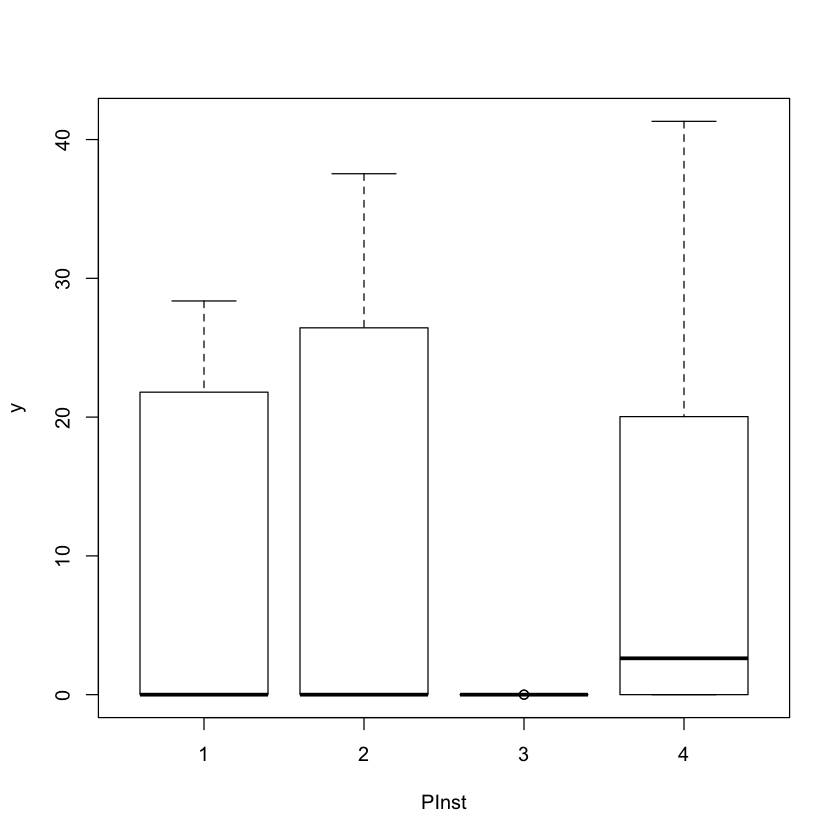

In [48]:
boxplot(Y ~ PInst, df01, xlab = "PInst", ylab = "y")

In [49]:
mean(df01[df01$PInst == 3,]$Y)
sd(df01[df01$PInst == 3,]$Y)

[1] 4.736952e-16

[1] 1.802705e-15

## The Corrected Data

In [50]:
df01 <- df01[df01$PInst != 3,]
# recalculate the factor levels:
df01$PInst <- factor(df01$PInst)
df01$Repeat <- factor(df01$Repeat)

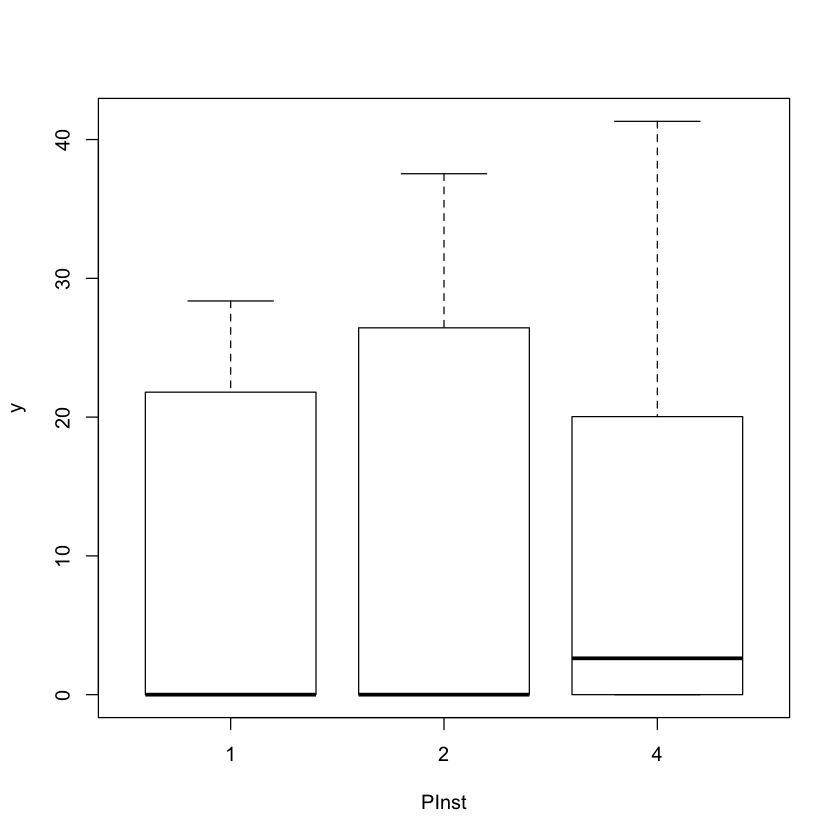

In [51]:
boxplot(Y ~ factor(PInst), df01, xlab = "PInst", ylab = "y")

## ANOVA

### Generate ANOVA Table

In [52]:
# note: a == n_pi == r 
a <- nlevels(df01$PInst)
n <- dim(df01)[1]/(a) # repeats (balanced design)
g <- lm(Y ~ PInst, data = df01)
g.anova <- anova(g)

In [53]:
g.anova

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PInst,2,140.213,70.1065,0.4486586,0.6399529
Residuals,87,13594.447,156.2580,NA,NA


### Extract MeanSq and df

In [54]:
round((MSA <- g.anova$`Mean Sq`[1]),2)
round((MSE <- g.anova$`Mean Sq`[2]),2)
(dfA <- g.anova$Df[1])
(dfE <- g.anova$Df[2])

[1] 70.11

[1] 156.26

[1] 2

[1] 87

## [SAMP-1] Perform Hypothesis Test

In [55]:
(F0.A <- MSA/MSE)
(qf(0.95, dfA, dfE))
# F* < F, we cannot reject the null hypothesis (there are no differences)
# This is also reflected in the large p-value:
(p.A <- 1-pf(F0.A,dfA,dfE))

[1] 0.4486586

[1] 3.101296

[1] 0.6399529

## [SAMP-2] Estimation of the Overall Mean

In [56]:
round((Ybar.. = mean(df01$Y) ),2)

[1] 8.93

In [57]:
alpha <- 0.1
sYbar.. <- sqrt(max(0, MSA/(a*n)) )
muLo95 <- Ybar.. - qt(1-alpha/2, a-1) * sYbar..
muHi95 <- Ybar.. + qt(1-alpha/2, a-1) * sYbar..

In [58]:
round( c(muLo95, muHi95),2)

[1]  6.36 11.51

## [SAMP-3] Plot of the Confidence Intervals of the Mean

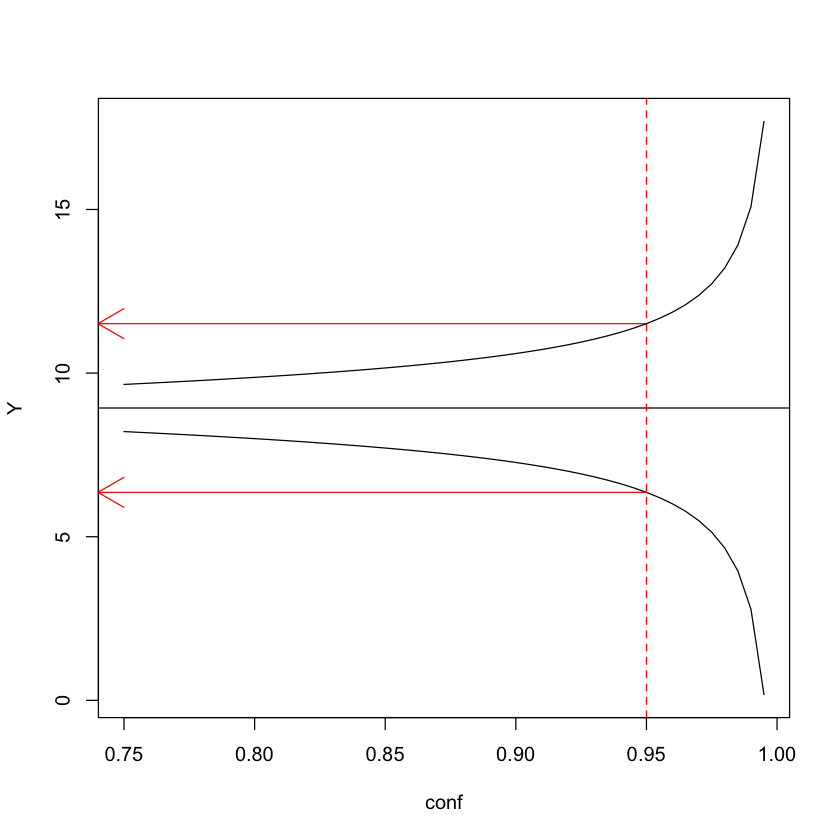

In [60]:
# note: a == n_pi in the text
alpha <- seq(0.01,0.5,0.01)
sYbar.. <- sqrt(max(0, MSA/(a*n)) )
muLo <- Ybar.. - qt(1-alpha/2, a-1) * sYbar..
muHi <- Ybar.. + qt(1-alpha/2, a-1) * sYbar..
conf <- 1- alpha/2

#pdf("confInt01.pdf")
plot(muLo~conf, type = "l", ylim=c(min(muHi,muLo), max(muHi,muLo) ), ylab="Y")
abline(Ybar..,0)
abline(v=0.95, lty=2, col = 2)
#abline(h=muLo95)
#abline(h=muHi95)
arrows(0.74, muHi95, 0.95, muHi95, col= 2, code =1)
arrows(0.74, muLo95, 0.95, muLo95, col= 2, code = 1)
lines(conf,muHi)
#dev.off()

## The Intraclass Correlation Coefficient

The ratio illustrates the variation between the $\mu_i$ values, i.e., the
variation of the performance values between different problem instances.
$$
\frac{\sigma_{\mu}^2}{\sigma_{\mu}^2 + \sigma^2}
$$

It compares 
1. the variance caused by the different runs of the algorithm with 
2. the variance caused by different problem instances.


In [61]:
alpha <- 0.1
L <- 1/n * (MSA/MSE * 1/ qf(1-alpha/2, a-1, a*(n-1)) -1)
U <- 1/n * (MSA/MSE * 1/ qf(alpha/2, a-1, a*(n-1)) -1)
Lstar <- max(0, L/(L+1) )
Ustar <- max(0, U/(U+1) )

With confidence coefficient $\alpha$, we conclude that that the variability of the 
mean performance values of the different problem instances $\pi_i$ accounts for 
between three  and 60 percent of the total variability in the 
performance values:

In [62]:
c(Lstar, Ustar)

[1] 0.0000000 0.2051247

## Estimation of Variance $\sigma^2$

In [63]:
sqrt( max(0, MSA)) 

[1] 8.372963

In [64]:
alpha=0.1
Lsigma2 <- a*(n-1)*MSA / qchisq(p=1-alpha/2, df=a*(n-1))
Usigma2 <- a*(n-1)*MSA / qchisq(p=alpha/2, df=a*(n-1))
c(Lsigma2, Usigma2)

[1] 55.56237 91.72118

In [65]:
sqrt(c(Lsigma2, Usigma2))

[1] 7.454017 9.577118


## Estimation of $\sigma_{\mu}^2$

An unbiased estimator of $\sigma_{\mu}^2$ is $(MSTR - MSE)/n$.
In some settings, this point estimator is negative. It is a usual practice to consider the 
estimator be be zero. This situation occurs in the SAMP example, which leads to the result:
$\hat{\sigma}^2_\mu = 0$.
Since exact confidence intervals for $\sigma_{\mu}^2$ cannot be determined,
\citet{satt46a} developed a procedure for calculating approximate $\sigma_{\mu}^2$ confidence intervals. 

In [66]:
(sMu <- sqrt( max(0, (MSA-MSE) / n) ))

[1] 0

# MAMP Putting the Pieces Together

We consider the 
2019-03-21.GLG.tuned.SPOT.GenSA.DEoptim.RS.mamp.RData
data set. New experiment (30.01.2019) with 
1. SPOT
2. DEopt
3. GenSA and 
4. RS (as baseline)
Beside randomly chosen problem instances, i.e., $PInst$, this data set contains 
results from different algorithms, i.e., $Algorithm$.

In [102]:
rm(resultDataFrame)
#load("2018-08-21.smoof.tuned.GenSA.SPOT.DEoptim.mamp.RData")
load("2019-03-21.GLG.tuned.SPOT.GenSA.DEoptim.RS.mamp.RData")
str(resultDataFrame)

'data.frame':	480 obs. of  24 variables:
 $ id          : num  1 2 3 4 5 6 7 8 9 10 ...
 $ repetition  : int  1 2 3 4 5 6 7 8 9 10 ...
 $ yBest       : num  9.56e-07 1.09e-05 1.08e-05 2.93e-06 5.67e-06 ...
 $ seed        : num  10010 10011 10012 10013 10014 ...
 $ budget      : num  240 240 240 240 240 240 240 240 240 240 ...
 $ designSize  : num  30 30 30 30 30 30 30 30 30 30 ...
 $ designType  : num  1 1 1 1 1 1 1 1 1 1 ...
 $ modelType   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ temp        : num  NA NA NA NA NA NA NA NA NA NA ...
 $ qv          : num  NA NA NA NA NA NA NA NA NA NA ...
 $ qa          : num  NA NA NA NA NA NA NA NA NA NA ...
 $ popsize     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ F           : num  NA NA NA NA NA NA NA NA NA NA ...
 $ CR          : num  NA NA NA NA NA NA NA NA NA NA ...
 $ c           : num  NA NA NA NA NA NA NA NA NA NA ...
 $ strategy    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ name        : chr  "SPOT" "SPOT" "SPOT" "SPOT" ...
 $ testInstance: int  

In [103]:
df02 <- data.frame(Y = resultDataFrame$yBest,
                   A = factor(resultDataFrame$name),
                   B = factor(resultDataFrame$testInstance))


In [104]:
levels(factor(resultDataFrame$name))

[1] "DEoptim" "GenSA"   "RS"      "SPOT"

In [105]:
summary(df02$Y[df02$A == "SPOT"])
#summary(df02$Y[df02$A == "RS"])
summary(df02$Y[df02$A == "GenSA"])
summary(df02$Y[df02$A == "DEoptim"])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000000  0.000007  0.000022  0.179028  0.000058 21.459331 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   11.25   21.46   22.94   40.91   47.53 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.06829  0.82062  1.86608  3.35133  3.97549 21.51819 

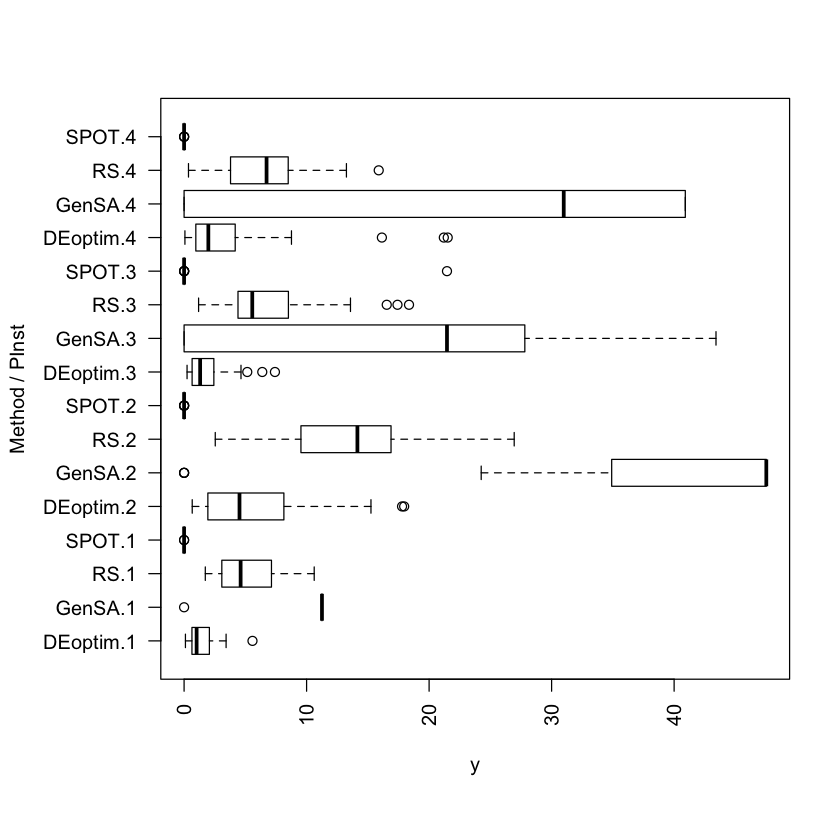

In [106]:
boxplot(Y ~ A+B , horizontal=T, df02, ylab = "Method / PInst", xlab = "", las=2, par(mgp=c(5.5, 1, 0),mar=c(6.7, 6.7, 4.1, 2.1)) ) 
mtext("y", side = 1, line = 3)

## ANOVA

In [107]:
a <- nlevels(df02$A)
b <- nlevels(df02$B)
n <- dim(df02)[1]/(a*b) # repeats (balanced design)
g <- lm(Y~(A + B)^2, data = df02)
(g.anova <- anova(g))
# xtable(g.anova)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
A,3,36517.973,12172.65781,213.83093,4.421707e-87
B,3,6009.553,2003.18438,35.18893,1.658606e-20
A:B,9,6630.046,736.67178,12.94074,1.773614e-18
Residuals,464,26413.921,56.92655,NA,NA


In [108]:
MSA <- g.anova$`Mean Sq`[1]
MSB <- g.anova$`Mean Sq`[2]
MSAB <- g.anova$`Mean Sq`[3]
MSE <- g.anova$`Mean Sq`[4]
dfA <- g.anova$Df[1]
dfB <- g.anova$Df[2]
dfAB <- g.anova$Df[3]
dfE <- g.anova$Df[4]

## [MAMP-1] Do the algorithms differ in performance?

In [109]:
# A denotes the algorithm factor
# F-value for A:
(F0.A <- MSA/MSAB)
# p value for A:
(p.A <- 1-pf(F0.A,dfA,dfAB))

[1] 16.52386

[1] 0.0005285273

## [MAMP-2] Do different problem instances affect the performance?

In [110]:
# B denotes the test instance factor
# F value for B:
(F0.B <- MSB/MSE)
# p value for B:
(p.B <- 1-pf(F0.B,dfB,dfE))

[1] 35.18893

[1] 0

## [MAMP-3] Do the algorithms a and problem instances $\pi_i$ interact?

In [111]:
# AB denotes the interaction
# F value for AB:
(F0.AB <- MSAB/MSE)
# p value for B:
(p.AB <- 1-pf(F0.AB,dfAB,dfE))

[1] 12.94074

[1] 0

## [MAMP-4] Estimation of the fixed factor effects

In [112]:
y.. <- mean(df02$Y)
y1. <- mean(df02$Y[df02$A == "SPOT"])
y2. <- mean(df02$Y[df02$A == "DEoptim"])
#y3. <- mean(df02$Y[df02$A == "RS"])
y4. <- mean(df02$Y[df02$A == "GenSA"])

tau1 <- y1. - y..
tau2 <- y2. - y..
#tau3 <- y3. - y..
tau4 <- y4. - y..
round( (c(tau1, tau2, 
          # tau3, 
          tau4)),2)


[1] -8.48 -5.31 14.28

## [MAMP-5] Confidence Intervals for Fixed Effects Contrasts

In [118]:
m1 <- mean(df02$Y[df02$A == "SPOT"])
m2 <- mean(df02$Y[df02$A == "DEoptim"])
m3 <- mean(df02$Y[df02$A == "RS"])
m4 <- mean(df02$Y[df02$A == "GenSA"])

s2L2 <- MSAB/(b*n)*(1+1+1+1)
sL <- sqrt(s2L2)
alpha <- 0.05
qt2 <- qt((1-alpha/2), dfAB)

d12 <- m1-m2
round(d12,2)
round( c( d12 - qt2*sL, d12 + qt2*sL),2)

d13 <- m1-m3
round(d13,2)
round(c( d13 - qt2*sL, d13 + qt2*sL),2)

d14 <- m1-m4
round(d14)
round( c( d14 - qt2*sL, d14 + qt2*sL),2)

d23 <- m2-m3
round(d23,2)
round(c( d23 - qt2*sL, d23 + qt2*sL),2)

d24 <- m2-m4
round(d24)
round(c( d24 - qt2*sL, d24 + qt2*sL),2)

d34 <- m3-m4
round(d34)
round(c( d34 - qt2*sL, d34 + qt2*sL),2)


[1] -3.17

[1] -14.38   8.04

[1] -7.99

[1] -19.20   3.22

[1] -23

[1] -33.97 -11.55

[1] -4.82

[1] -16.03   6.39

[1] -20

[1] -30.80  -8.38

[1] -15

[1] -25.98  -3.56

[1] -5.65  6.01

[1] -2.48  9.18

[1]  2.34 14.00

[1] 17.11 28.77

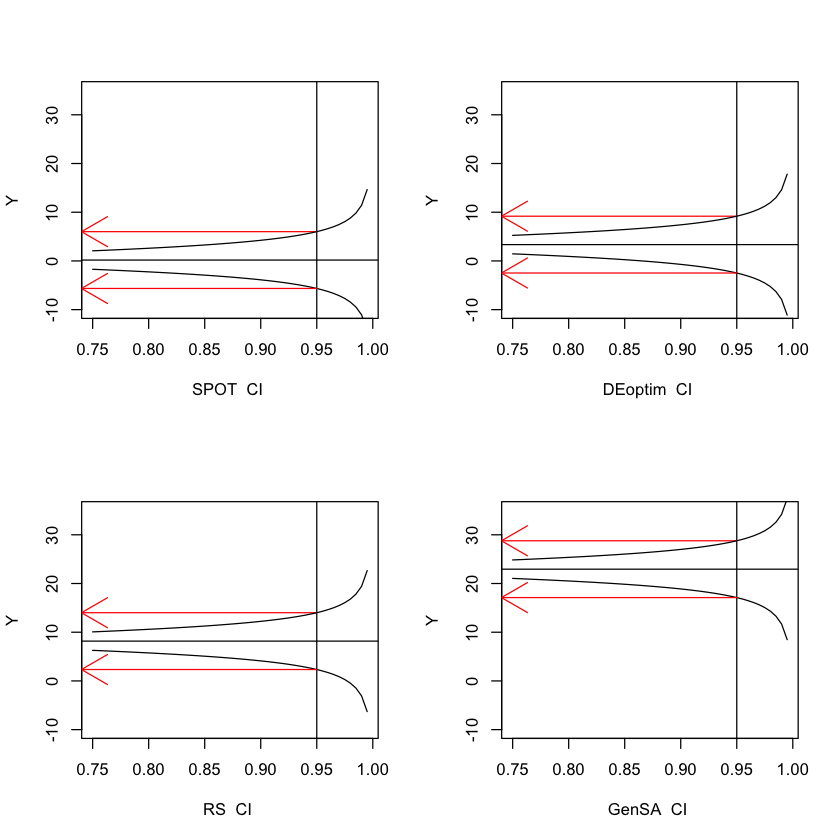

In [120]:
m1 <- mean(df02$Y[df02$A == "SPOT"])
m2 <- mean(df02$Y[df02$A == "DEoptim"])
#m3 <- mean(df02$Y[df02$A == "RS"])
m4 <- mean(df02$Y[df02$A == "GenSA"])

sYbar.. <- sqrt(max(0, MSAB/(b*n)) )

plotConfInt <- function(ybar, sYbar..,dfree=(a-1), alg="", val=""){
    muLo95 <- ybar - qt(0.95, dfree) * sYbar..
    muHi95 <- ybar + qt(0.95, dfree) * sYbar..
alpha <- seq(0.01,0.5,0.01)
conf <- 1- alpha/2
muLo <- ybar - qt(conf, dfree) * sYbar..
muHi <- ybar + qt(conf, dfree) * sYbar..
# plot(muLo~conf, type = "l", ylim=c(min(muHi,muLo), max(muHi,muLo) ), ylab="Y")
plot(muLo~conf, type = "l", ylim=c(-10, 35 ),  xlab = paste(alg, " CI", val), ylab="Y")
abline(ybar,0)
abline(v=0.95)
    arrows(0.74, muHi95, 0.95, muHi95, col= 2, code =1)
arrows(0.74, muLo95, 0.95, muLo95, col= 2, code = 1)
lines(conf,muHi)
return( round( c(ybar - qt(0.95, dfree) * sYbar..,  ybar + qt(0.95, dfree) * sYbar..),2))
 }
#pdf("confInt.pdf")
par(mfrow=c(2,2))
plotConfInt(ybar=m1, sYbar..=sYbar..,dfree=(a-1),alg="SPOT")
plotConfInt(ybar=m2, sYbar..=sYbar..,dfree=(a-1), alg="DEoptim")
plotConfInt(ybar=m3, sYbar..=sYbar..,dfree=(a-1), alg="RS")
plotConfInt(ybar=m4, sYbar..=sYbar..,dfree=(a-1), alg="GenSA")
par(mfrow=c(1,1))
#dev.off()

## [MAMP-6] Estimators of the marginal mean

In [125]:
y1. <- mean(df02$Y[df02$A == "SPOT"])
y2. <- mean(df02$Y[df02$A == "DEoptim"])
y3. <- mean(df02$Y[df02$A == "RS"])
y4. <- mean(df02$Y[df02$A == "GenSA"])
round( (c(y1., y2., 
          y3., 
          y4.)),2)

[1]  0.18  3.35  8.17 22.94

## [MAMP-7] Confidence intervals for Marginal Means

In [126]:
# The Satterthwaite procedure can be used to estimate the magnitude 
# of the variance component $\sigma_\beta^2$, when the random factor has significant main effects. 
# It is included in the R package SPOT 
# https://cran.r-project.org/web/packages/SPOT/index.html
# source("../../../spot2/sourceDevelopment/misc/satter.R")
c1 <- (a-1)/(n*a*b)
c2 <- 1/(n*a*b)
satres <- satter(MScoeff=c(c1, c2),
       MSi=c(MSAB,MSB),
       dfi =c((a-1)*(b-1),(b-1)),
       alpha=0.1)
dfsat <- satres[,"df"]

smuei <- sqrt( max(0, c1*MSAB + c2*MSB)) # (25.64)

[1] -5.25  5.61

[1] -2.08  8.78

[1]  2.74 13.60

[1] 17.51 28.37

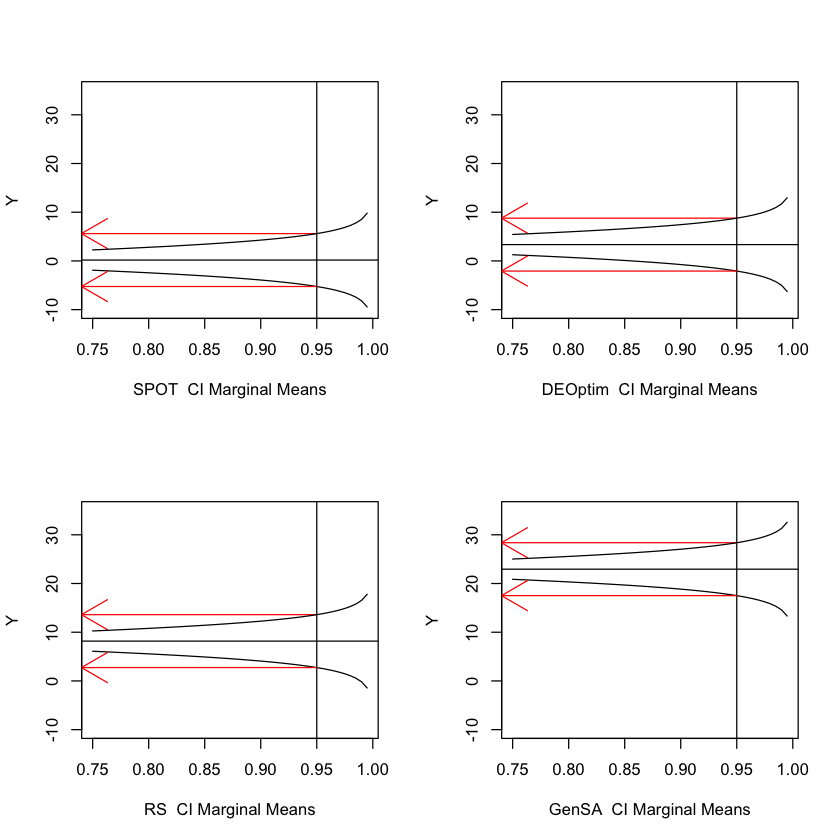

In [127]:
# pdf("confInt.pdf")
par(mfrow=c(2,2))
plotConfInt(ybar=y1., sYbar..=smuei,dfree=dfsat, alg="SPOT", val="Marginal Means")
plotConfInt(ybar=y2., sYbar..=smuei,dfree=dfsat, alg="DEOptim", val="Marginal Means")
plotConfInt(ybar=y3., sYbar..=smuei,dfree=dfsat, alg="RS", val="Marginal Means")
plotConfInt(ybar=y4., sYbar..=smuei,dfree=dfsat, alg="GenSA", val="Marginal Means")
par(mfrow=c(1,1))
#dev.off()

## [MAMP-8] Estimation of the variance components

In [128]:
var.beta <- (MSB-MSE)/(a*n)
var.tau.beta <- (MSAB-MSE)/n
var <- MSE
round( (c(var.beta, var.tau.beta, var)),2)

[1] 16.22 22.66 56.93

In [129]:
## Check if the estimated of the interaction variance component $\sigma_{\tau\beta}^2$ is negative,
## fit a reduced model, without interactions A*B
if(var.tau.beta < 0) {
  h <- lm(Y ~ A + B, data = df02)
  (h.anova <- anova(h))
  xtable(h.anova)
  MSA <- h.anova$`Mean Sq`[1]
  MSB <- h.anova$`Mean Sq`[2]
  MSE <- h.anova$`Mean Sq`[3]
  (var.beta <- (MSB-MSE)/(a*n))
}
var.beta

[1] 16.21882

In [130]:
# The Satterthwaite procedure can be used to estimate the magnitude of the variance component $\sigma_\beta^2$, when the random factor has significant main effects. 
# source("../../../spot2/sourceDevelopment/misc/satter.R")
resS <- satter(MScoeff=c(1/(n*a), -1/(n*a)),
       MSi=c(MSB,MSE),
       dfi =c(b-1,(n-1)*a*b),
       alpha=0.1)
# Note, the output from the \texttt{satter()} procedure is $\sigma_\beta$, i.e., we have to consider: 
# <<sqrtVarBeta>>=
#  sqrt(var.beta)
# @
round (resS,2)

estimate,df,lower,upper
16.22,3,6.23,138.29


## Using nlme

Y,A,B
9.563410e-07,SPOT,1
1.091241e-05,SPOT,1
1.082825e-05,SPOT,1
2.926531e-06,SPOT,1
5.668585e-06,SPOT,1
1.745022e-06,SPOT,1


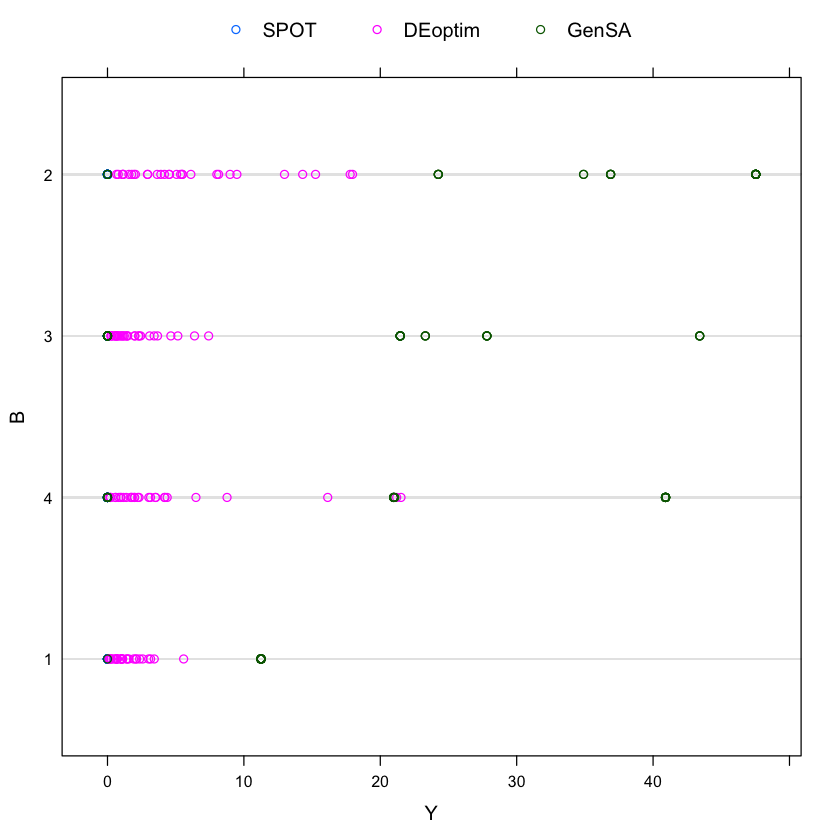

In [131]:
library(nlme)
head(masprep01 <- groupedData( Y ~ A | B, data = df02) )
#levels(masprep01$A)
#levels(masprep01$A) <- c("x2", "x4", "x3", "x1")
#masprep01$A <- ordered(masprep01$A, levels = c("x1", "x2", "x3", "x4"))
masprep01$A <- ordered(masprep01$A, levels = c("SPOT", "DEoptim", 
                                               #"RS", 
                                               "GenSA"))
#masprep01$A <- factor(masprep01$A, ordered = FALSE)
plot(masprep01)
#factor(masprep01$A, ordered = FALSE)

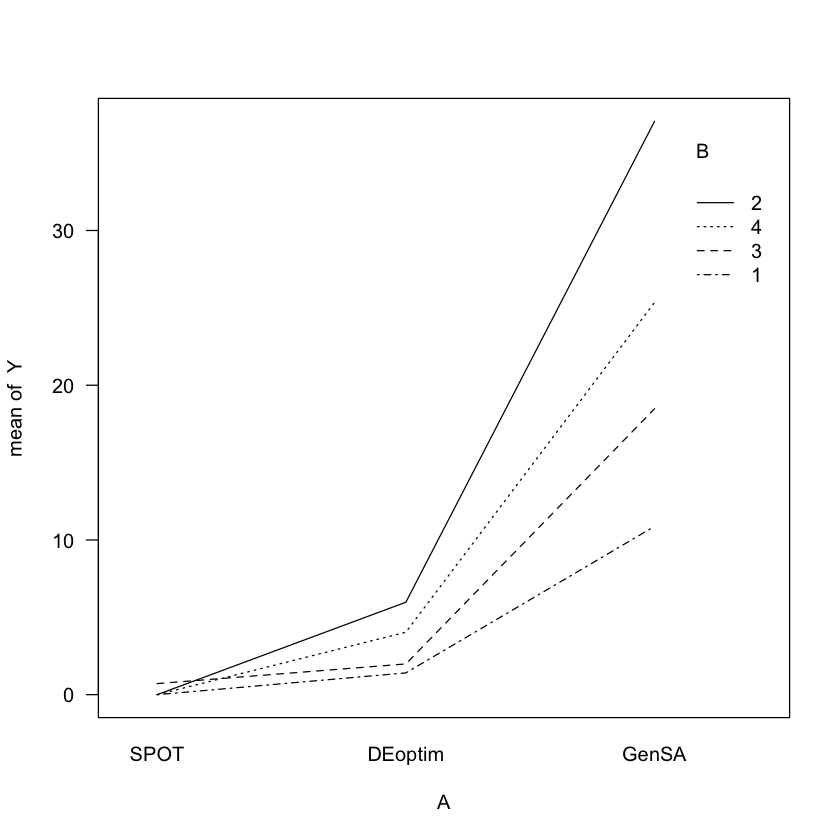

In [132]:
with( masprep01, 
     interaction.plot(A, B, Y, las = 1))